# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import librosa
import librosa.display
import IPython.display as ipd

# from functions import *

import skimage.io
import wave


import tensorflow as tf
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [39]:
# df_train = pd.read_csv("df_train.csv")
# df_train = df_train.sample(frac = 1)
# df_train.drop("Unnamed: 0", inplace = True, axis = 1)

In [86]:
# df_train.head()

# Functions

In [4]:
def print_results(model, X_train, y_train,X_test, y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
        
        
    score = {}
    
    score["test_recall"]  = report["abnormal"]["TEST"]["recall"]
    score["train_recall"] = report["abnormal"]["TRAIN"]["recall"]
    
    score["test_precision"]  = report["abnormal"]["TEST"]["precision"]
    score["train_precision"] = report["abnormal"]["TRAIN"]["precision"]
    
    score["test_f1-score"]  = report["abnormal"]["TEST"]["f1-score"]
    score["train_f1-score"] = report["abnormal"]["TRAIN"]["f1-score"]
    
    score["test_accuracy"]  = report["accuracy"]["TEST"]["recall"]
    score["train_accuracy"] = report["accuracy"]["TRAIN"]["recall"]
    
    return report, score

# Converting Audio to Tensors

This code is from [here](https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb) 

In [5]:
def get_wave(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  ## The output needs to be decoded by using the next line
    ## Next line gives a numerical values of an audio file and the output needs to be reshaped
    # Decode wav (tensors by channels) ## Desired Channel = 1 means not sterio type
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) 
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(336608,)


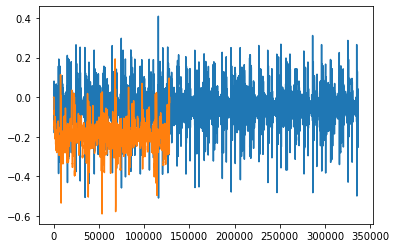

In [6]:
normal_path = df_train["path"].iloc[6]
normal_wav = get_wave(normal_path)

abnormal_path = df_train["path"].iloc[5]
abnormal_wav = get_wave(abnormal_path)


print(normal_wav.shape)
plt.plot(normal_wav)
plt.plot(abnormal_wav)
plt.show();

Because the tensors will have different length, we will need to pad them with 0's. To do that we use the following function, this function is adopted from [here](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [7]:
def zero_padding(filename, input_len):
    waveform = get_wave(filename)
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform),
      dtype=tf.float32)
    
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    return equal_length
    

# Importing Train-Test Sets

In [52]:
X_train_df = pd.read_csv("../Train-Test-Split/X_train_df.csv")
y_train_df = pd.read_csv("../Train-Test-Split/y_train_df.csv")

X_test_df = pd.read_csv("../Train-Test-Split/X_test_df.csv")
y_test_df = pd.read_csv("../Train-Test-Split/y_test_df.csv")

X_train_df.drop("Unnamed: 0", inplace = True, axis = 1)
X_test_df.drop("Unnamed: 0", inplace = True, axis = 1)

y_train_df.drop("Unnamed: 0", inplace = True, axis = 1)
y_test_df.drop("Unnamed: 0", inplace = True, axis = 1)

In [42]:
# y_df = df_train["target"]
# X_df = df_train.drop("target", axis = 1)

# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df,
#                                                                test_size=0.2, 
#                                                                random_state=42,
#                                                                stratify=y_df)

# X_train_df.to_csv("../Train-Test-Split/X_train_df.csv")
# y_train_df.to_csv("../Train-Test-Split/y_train_df.csv")

# X_test_df.to_csv("../Train-Test-Split/X_test_df.csv")
# y_test_df.to_csv("../Train-Test-Split/y_test_df.csv")

# Preparing Numerical Data

In [53]:
length_lr = 5*10**4
delta = 5000

# data_ML = X_train_df.copy()

X_train= pd.DataFrame(columns = list(range(0, delta)), index = X_train_df.index)
print("X_train ZERO  DONE!")


for i in range(0,len(X_train_df)):
    path   = X_train_df["path"].iloc[i]
    values = get_wave(path)[length_lr-delta:length_lr].numpy()
    X_train.iloc[i] = pd.DataFrame(values).transpose()
    
# data_ML["values"] = data_ML["path"].apply(lambda x: 
#                                           get_wave(x)[length_lr-delta:length_lr].numpy())
print("X_train is DONE")

X_train ZERO  DONE!
X_train is DONE


In [54]:
X_test = pd.DataFrame(columns = list(range(0, delta)), index = X_test_df.index)
print("X_test ZERO  DONE!")

for i in range(0,len(X_test_df)):
    path   = X_test_df["path"].iloc[i]
    values = get_wave(path)[length_lr-delta:length_lr].numpy()
    X_test.iloc[i] = pd.DataFrame(values).transpose()
print("X_test is DONE")

X_test ZERO  DONE!
X_test is DONE


In [55]:
X_train_df.head()

,name,num_2,path
0,e00342,1,../train_test_original/training-e/e00342.wav
1,e01135,1,../train_test_original/training-e/e01135.wav
2,e00070,1,../train_test_original/training-e/e00070.wav
3,e01094,0,../train_test_original/training-e/e01094.wav
4,e01658,1,../train_test_original/training-e/e01658.wav


In [57]:
le = LabelEncoder()
y_train = le.fit_transform(pd.DataFrame(y_train_df))
y_test  = le.transform(pd.DataFrame(y_test_df))


# PCA 

53
0.950840490626438


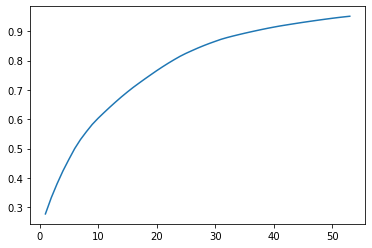

In [58]:
l = []
pca_n = list(range(1, 60))
for i in pca_n:
    pca = PCA(n_components = i)
    pca.fit_transform(X_train.values)
    l.append(list(pca.explained_variance_ratio_.cumsum())[-1])
    if l[-1] >= 0.95:
        n = i
        print(i)
        print(l[-1])
        break
    
plt.plot(range(1, n+1), l);

## Train-Test PCA

In [59]:
pca_95 = PCA(n_components = n)
X_train_pca = pca_95.fit_transform(X_train.values)
X_test_pca  = pca_95.transform(X_test.values)

## Train-Test SMOTE

In [60]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Train-Test PCA-SMOTE

In [61]:
pca_95 = PCA(n_components = n)
X_train_smote_pca = pca_95.fit_transform(X_train_smote.values)
X_test_pca  = pca_95.transform(X_test.values)

# Modeling

In [62]:
model_scores = {}

## Logistic Regression

### Train-Test Original 

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.26     0.85      0.56       0.55          0.73
      recall         0.62     0.55      0.56       0.58          0.56
      f1-score       0.37     0.67      0.56       0.52          0.60
      support      133.00   515.00      0.56     648.00        648.00
TRAIN precision      0.33     0.90      0.64       0.62          0.78
      recall         0.74     0.61      0.64       0.68          0.64
      f1-score       0.46     0.73      0.64       0.59          0.67
      support      532.00  2060.00      0.64    2592.00       2592.00

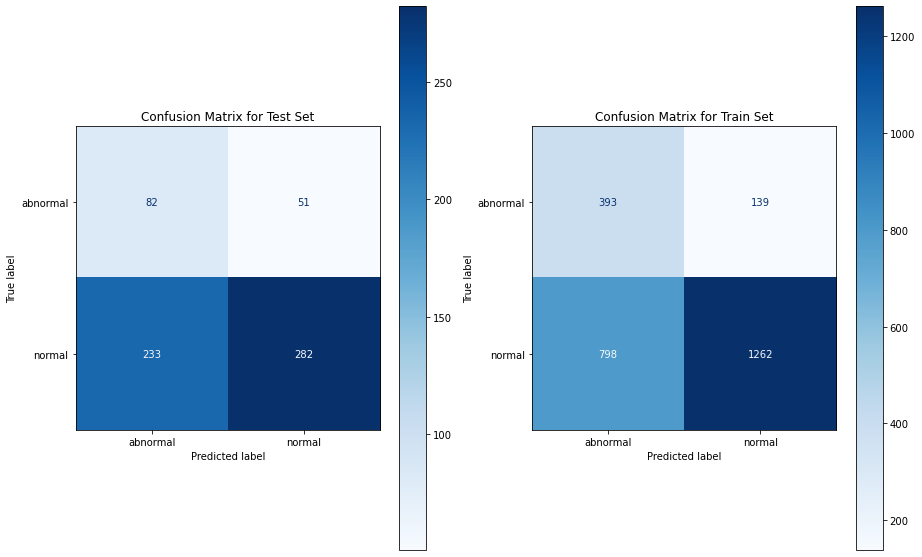

In [63]:
lr = LogisticRegression(solver='liblinear',random_state=42, class_weight="balanced")
lr.fit(X_train, y_train)
print("Fitting Done!")
report, model_scores["lr"] = print_results(lr, X_train, y_train,
                                           X_test, y_test)
report

### Train-Test PCA 


Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.27     0.85      0.58       0.56          0.73
      recall         0.62     0.56      0.58       0.59          0.58
      f1-score       0.38     0.68      0.58       0.53          0.62
      support      133.00   515.00      0.58     648.00        648.00
TRAIN precision      0.28     0.88      0.55       0.58          0.75
      recall         0.72     0.51      0.55       0.62          0.55
      f1-score       0.40     0.65      0.55       0.52          0.59
      support      532.00  2060.00      0.55    2592.00       2592.00

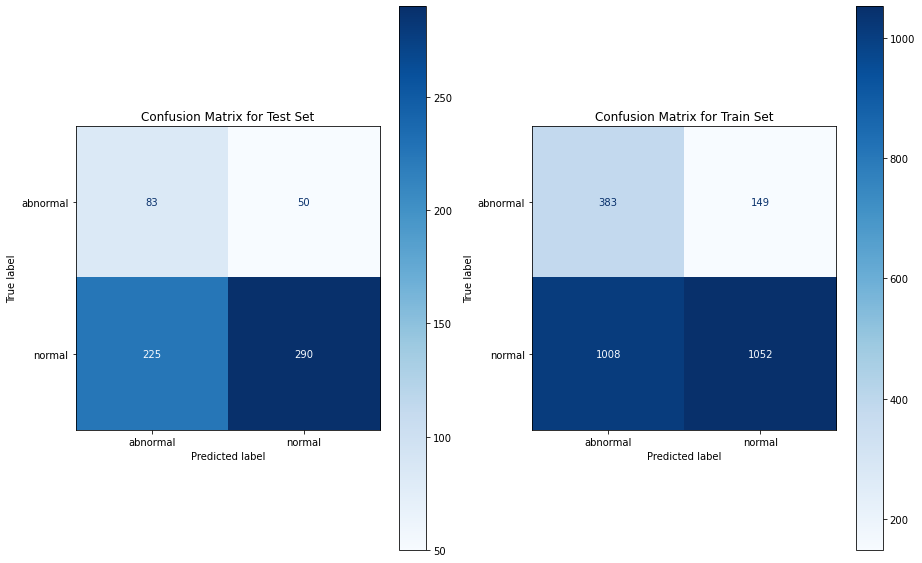

In [64]:
lr_pca = LogisticRegression(solver='liblinear',random_state=42, class_weight="balanced")
lr_pca.fit(X_train_pca, y_train)
print("Fitting Done!")
report, model_scores["lr_pca"] = print_results(lr_pca, X_train_pca, 
                                          y_train, X_test_pca, y_test)
report

### Train-Test SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.26     0.85      0.55       0.56          0.73
      recall         0.65     0.52      0.55       0.59          0.55
      f1-score       0.37     0.65      0.55       0.51          0.59
      support      133.00   515.00      0.55     648.00        648.00
TRAIN precision      0.67     0.77      0.71       0.72          0.72
      recall         0.82     0.60      0.71       0.71          0.71
      f1-score       0.74     0.68      0.71       0.71          0.71
      support     2060.00  2060.00      0.71    4120.00       4120.00

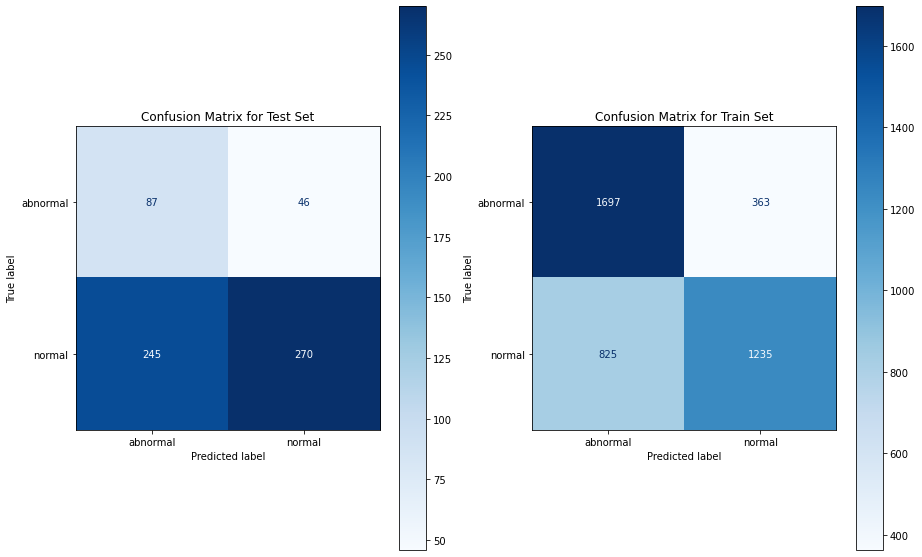

In [65]:
lr_smote = LogisticRegression(solver='liblinear',random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
print("Fitting Done!")

report, model_scores["lr_smote"] = print_results(lr_smote, X_train_smote, 
                                                y_train_smote, X_test, y_test)

report

### Train-Test SMOTE PCA 

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.27     0.88      0.52       0.57          0.76
      recall         0.76     0.46      0.52       0.61          0.52
      f1-score       0.40     0.61      0.52       0.50          0.56
      support      133.00   515.00      0.52     648.00        648.00
TRAIN precision      0.60     0.69      0.63       0.64          0.64
      recall         0.78     0.48      0.63       0.63          0.63
      f1-score       0.68     0.56      0.63       0.62          0.62
      support     2060.00  2060.00      0.63    4120.00       4120.00

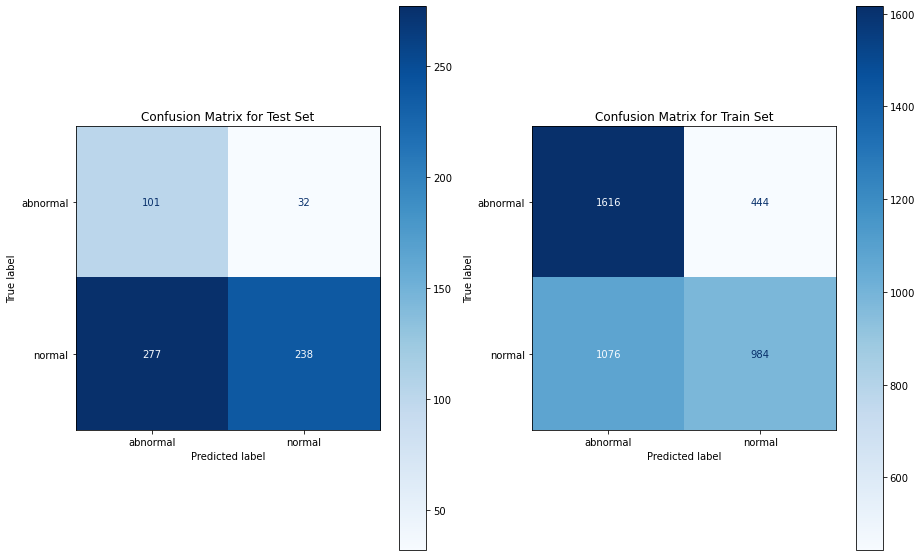

In [66]:
lr_smote_pca = LogisticRegression(solver='liblinear',random_state=42)
lr_smote_pca.fit(X_train_smote_pca, y_train_smote)
print("Fitting Done!")

report, model_scores["lr_smote_pca"] = print_results(lr_smote_pca, 
                                                      X_train_smote_pca, 
                                                      y_train_smote,
                                                      X_test_pca, y_test)

report

## Decision Tree

### Train-Test Original 

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.31     0.83       0.7       0.57          0.73
      recall         0.40     0.77       0.7       0.59          0.70
      f1-score       0.35     0.80       0.7       0.58          0.71
      support      133.00   515.00       0.7     648.00        648.00
TRAIN precision      1.00     1.00       1.0       1.00          1.00
      recall         1.00     1.00       1.0       1.00          1.00
      f1-score       1.00     1.00       1.0       1.00          1.00
      support      532.00  2060.00       1.0    2592.00       2592.00

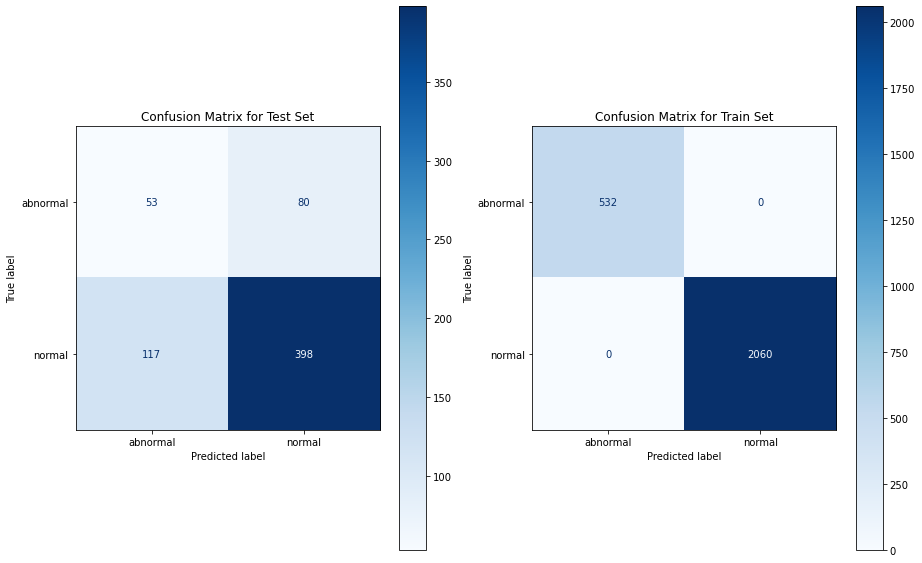

In [67]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Fitting Tree")
report, model_scores["tree"] = print_results(tree, X_train, y_train, 
                                              X_test, y_test)

report

### Train-Test PCA 

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.34     0.81      0.75       0.58          0.72
      recall         0.22     0.89      0.75       0.55          0.75
      f1-score       0.26     0.85      0.75       0.56          0.73
      support      133.00   515.00      0.75     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support      532.00  2060.00      1.00    2592.00       2592.00

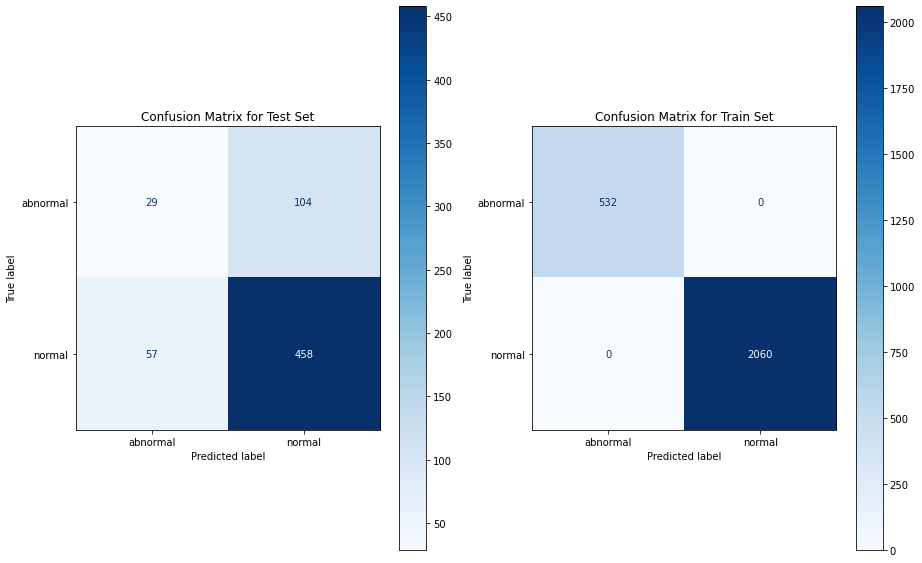

In [68]:
tree_pca = DecisionTreeClassifier()
tree_pca.fit(X_train_pca, y_train)

print("Fitting Tree")
report, model_scores["tree_pca"] = print_results(tree_pca, X_train_pca,
                                              y_train, X_test_pca, y_test)

report

### Train-Test SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.25     0.81      0.65       0.53          0.70
      recall         0.35     0.72      0.65       0.54          0.65
      f1-score       0.29     0.76      0.65       0.53          0.67
      support      133.00   515.00      0.65     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support     2060.00  2060.00      1.00    4120.00       4120.00

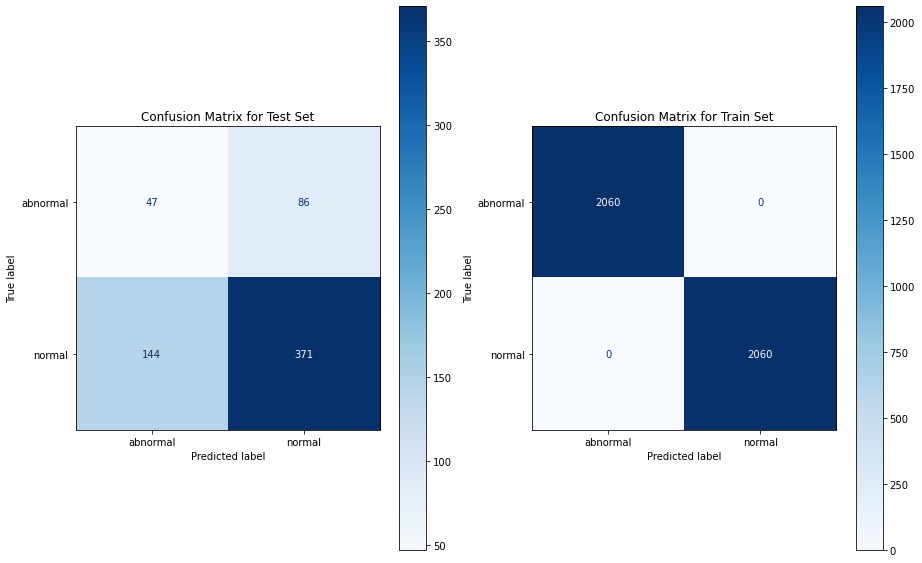

In [69]:
tree_smote = DecisionTreeClassifier()
tree_smote.fit(X_train_smote, y_train_smote)
print("Fitting Done!")
report, model_scores["tree_smote"] = print_results(tree_smote, X_train_smote,
                                                    y_train_smote, X_test,
                                                    y_test)
report

### Train-Test SMOTE PCA

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.30     0.83      0.68       0.56          0.72
      recall         0.41     0.75      0.68       0.58          0.68
      f1-score       0.34     0.79      0.68       0.57          0.70
      support      133.00   515.00      0.68     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support     2060.00  2060.00      1.00    4120.00       4120.00

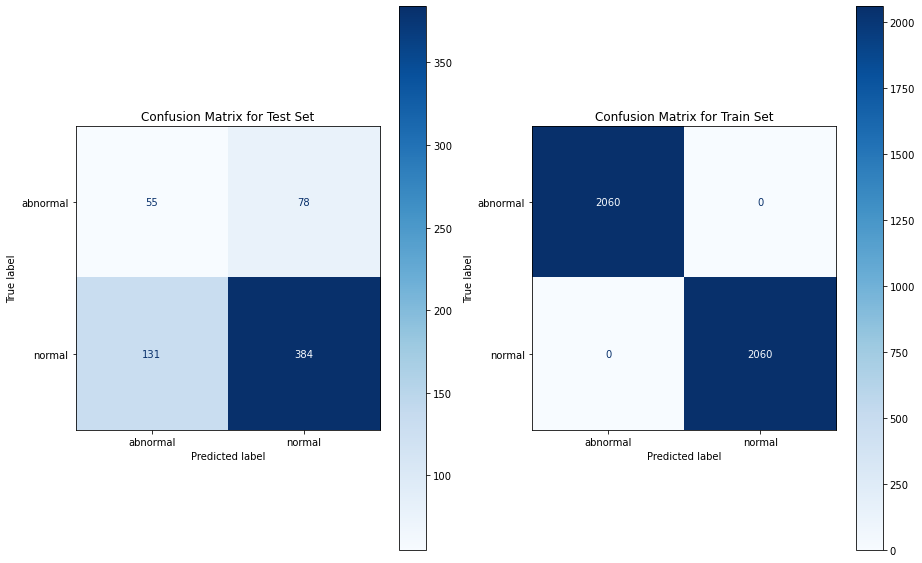

In [70]:
tree_smote_pca = DecisionTreeClassifier()
tree_smote_pca.fit(X_train_smote_pca, y_train_smote)
print("Fitting Done!")
report, model_scores["tree_smote_pca"] = print_results(tree_smote_pca, 
                                                        X_train_smote_pca,
                                                        y_train_smote, 
                                                        X_test_pca, y_test)

report

## Random Forest

### Train-Test Original

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.36     0.86      0.71       0.61          0.76
      recall         0.52     0.76      0.71       0.64          0.71
      f1-score       0.43     0.81      0.71       0.62          0.73
      support      133.00   515.00      0.71     648.00        648.00
TRAIN precision      0.55     0.95      0.83       0.75          0.87
      recall         0.83     0.82      0.83       0.83          0.83
      f1-score       0.66     0.88      0.83       0.77          0.84
      support      532.00  2060.00      0.83    2592.00       2592.00

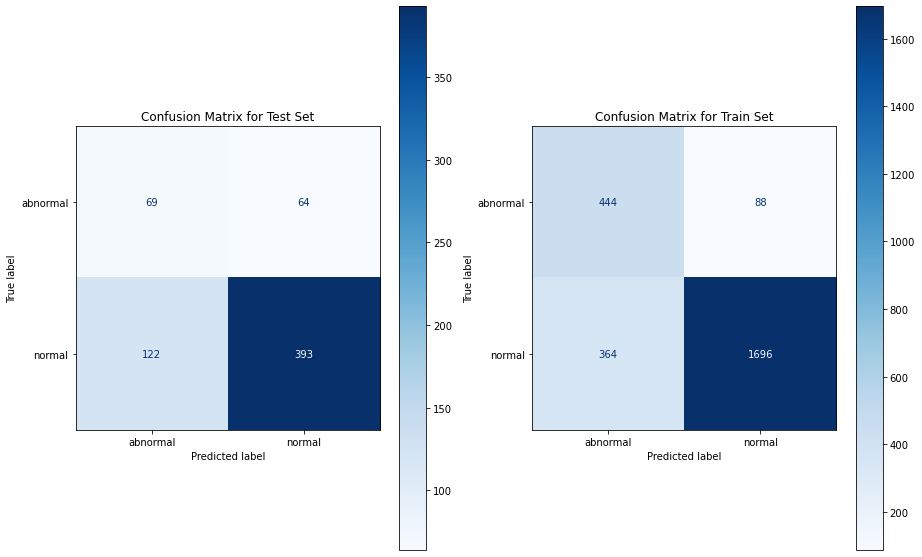

In [71]:
forest = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
                                class_weight = "balanced",
                                random_state = 42)

forest.fit(X_train, y_train)

print("Fitting Tree")
report, model_scores["forest"] = print_results(forest, X_train, y_train, 
                                               X_test, y_test)

report

### Train-Test PCA

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.48     0.82      0.79       0.65          0.75
      recall         0.22     0.94      0.79       0.58          0.79
      f1-score       0.30     0.88      0.79       0.59          0.76
      support      133.00   515.00      0.79     648.00        648.00
TRAIN precision      0.49     0.94      0.79       0.72          0.85
      recall         0.81     0.79      0.79       0.80          0.79
      f1-score       0.61     0.86      0.79       0.73          0.81
      support      532.00  2060.00      0.79    2592.00       2592.00

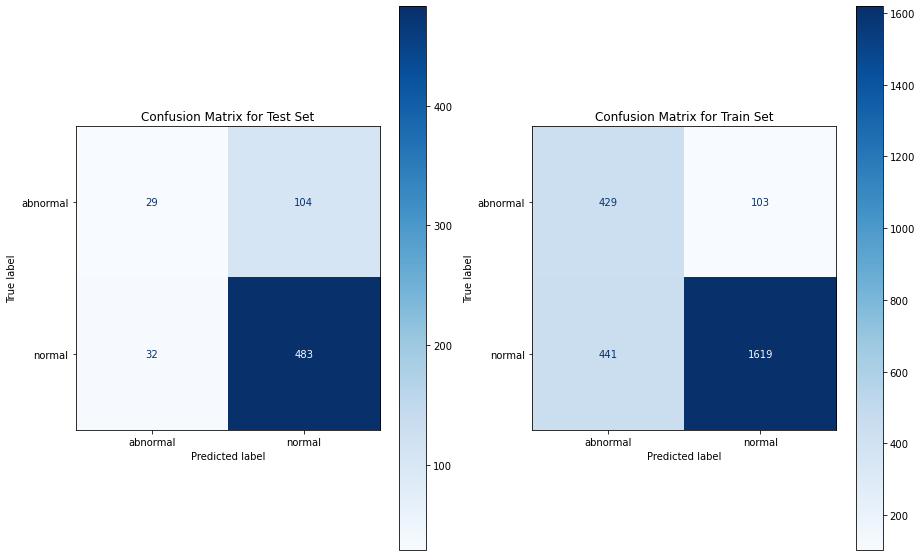

In [72]:
forest_pca = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
                                class_weight = "balanced",
                                random_state = 42)

forest_pca.fit(X_train_pca, y_train)

print("Fitting Tree")
report, model_scores["forest_pca"] = print_results(forest_pca, X_train_pca,
                                               y_train, X_test_pca, y_test)

report

### Train-Test SMOTE


Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.32     0.86      0.66       0.59          0.75
      recall         0.58     0.68      0.66       0.63          0.66
      f1-score       0.41     0.76      0.66       0.59          0.69
      support      133.00   515.00      0.66     648.00        648.00
TRAIN precision      0.81     0.88      0.84       0.84          0.84
      recall         0.89     0.80      0.84       0.84          0.84
      f1-score       0.85     0.83      0.84       0.84          0.84
      support     2060.00  2060.00      0.84    4120.00       4120.00

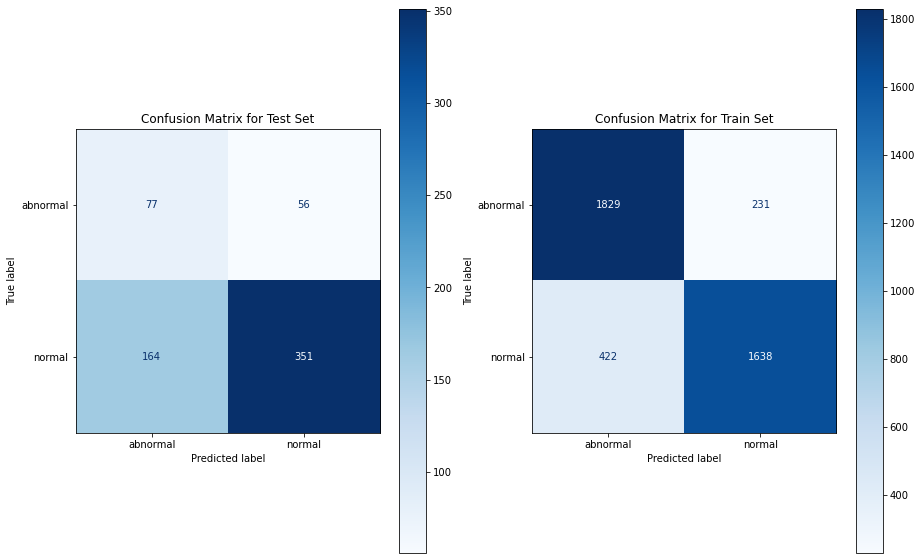

In [73]:
forest_smote = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
#                                 class_weight = "balanced",
                                random_state = 42)

forest_smote.fit(X_train_smote, y_train_smote)

print("Fitting Tree")
report, model_scores["forest_smote"] = print_results(forest_smote, X_train_smote, 
                                               y_train_smote, X_test, y_test)

report

### Train-Test SMOTE PCA

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.39     0.88      0.73       0.64          0.78
      recall         0.59     0.76      0.73       0.68          0.73
      f1-score       0.47     0.82      0.73       0.64          0.75
      support      133.00   515.00      0.73     648.00        648.00
TRAIN precision      0.78     0.80      0.79       0.79          0.79
      recall         0.81     0.77      0.79       0.79          0.79
      f1-score       0.80     0.79      0.79       0.79          0.79
      support     2060.00  2060.00      0.79    4120.00       4120.00

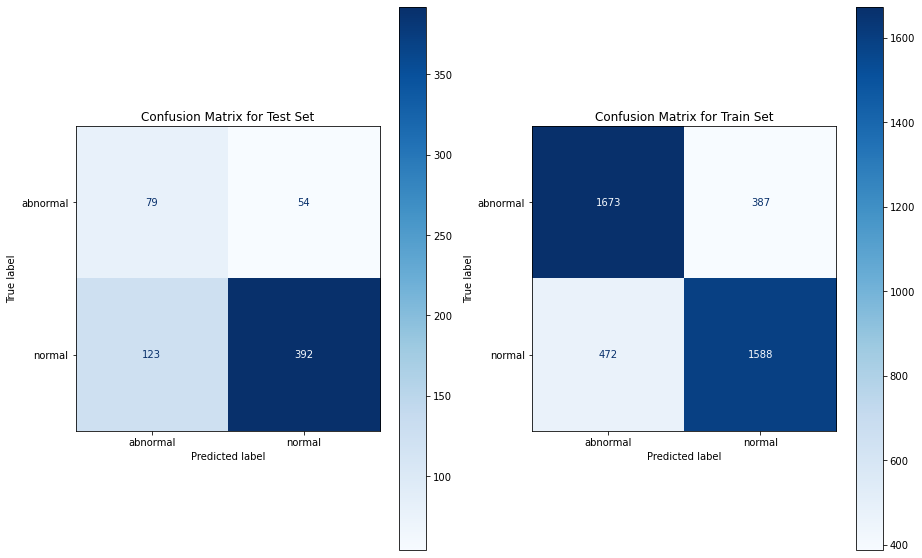

In [74]:
forest_smote_pca = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
#                                 class_weight = "balanced",
                                random_state = 42)

forest_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Tree")
report, model_scores["forest_smote_pca"] = print_results(forest_smote_pca, 
                                               X_train_smote_pca,
                                               y_train_smote, X_test_pca,
                                               y_test)

report

## XGBoost

### Train-Test Original

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.61     0.82      0.81       0.71          0.78
      recall         0.17     0.97      0.81       0.57          0.81
      f1-score       0.26     0.89      0.81       0.57          0.76
      support      133.00   515.00      0.81     648.00        648.00
TRAIN precision      0.99     0.93      0.94       0.96          0.95
      recall         0.72     1.00      0.94       0.86          0.94
      f1-score       0.84     0.96      0.94       0.90          0.94
      support      532.00  2060.00      0.94    2592.00       2592.00

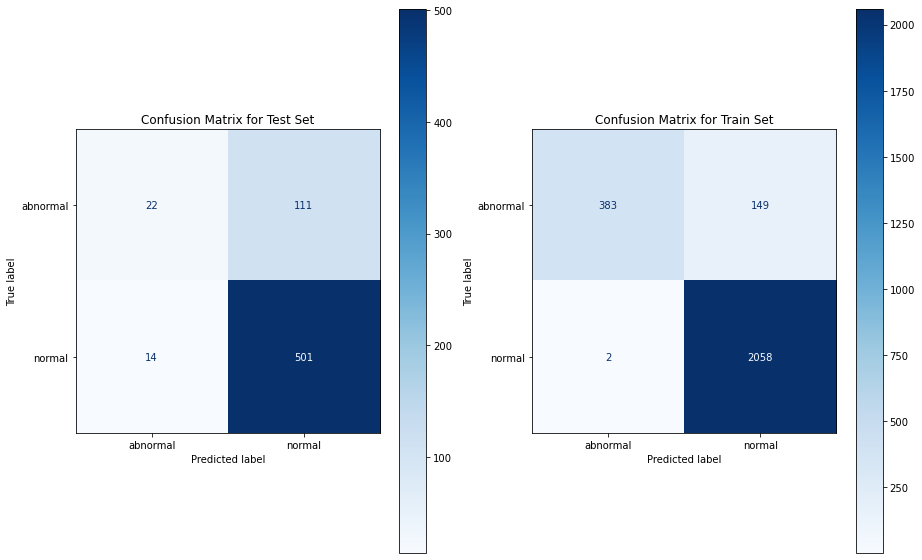

In [75]:
xg = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg.fit(X_train.values, y_train)

print("Fitting Done")
report, model_scores["XGBoost"] = print_results(xg, X_train.values,
                                                         y_train, X_test.values,
                                                         y_test)

report

### Train-Test PCA

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.77     0.82      0.82       0.79          0.81
      recall         0.15     0.99      0.82       0.57          0.82
      f1-score       0.25     0.90      0.82       0.57          0.76
      support      133.00   515.00      0.82     648.00        648.00
TRAIN precision      0.95     0.92      0.92       0.93          0.92
      recall         0.66     0.99      0.92       0.83          0.92
      f1-score       0.78     0.95      0.92       0.87          0.92
      support      532.00  2060.00      0.92    2592.00       2592.00

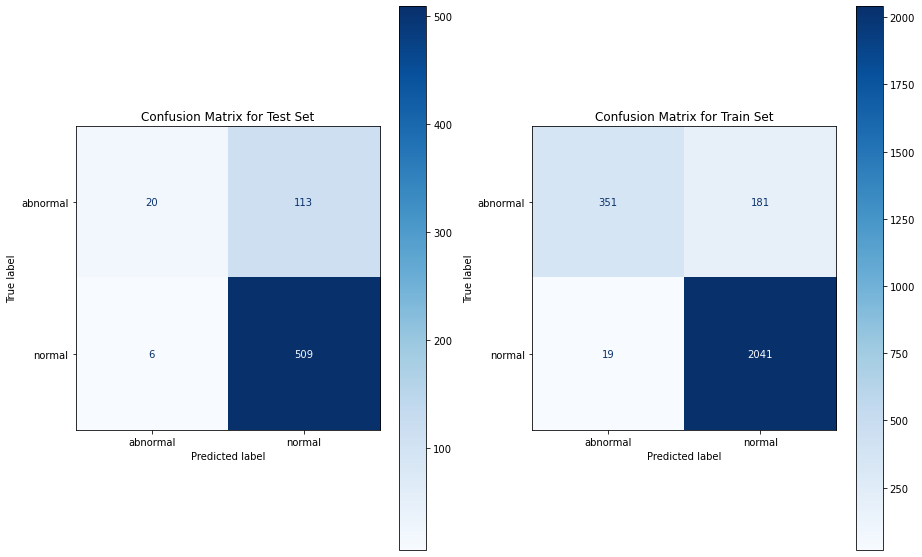

In [76]:
xg_pca = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_pca.fit(X_train_pca, y_train)

print("Fitting Done")
report, model_scores["XGBoost_pca"] = print_results(xg_pca, X_train_pca,
                                                y_train, X_test_pca, y_test)

report

### Train-Test SMOTE

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.44     0.88      0.76       0.66          0.79
      recall         0.59     0.81      0.76       0.70          0.76
      f1-score       0.50     0.84      0.76       0.67          0.77
      support      133.00   515.00      0.76     648.00        648.00
TRAIN precision      0.98     0.99      0.99       0.99          0.99
      recall         0.99     0.98      0.99       0.99          0.99
      f1-score       0.99     0.99      0.99       0.99          0.99
      support     2060.00  2060.00      0.99    4120.00       4120.00

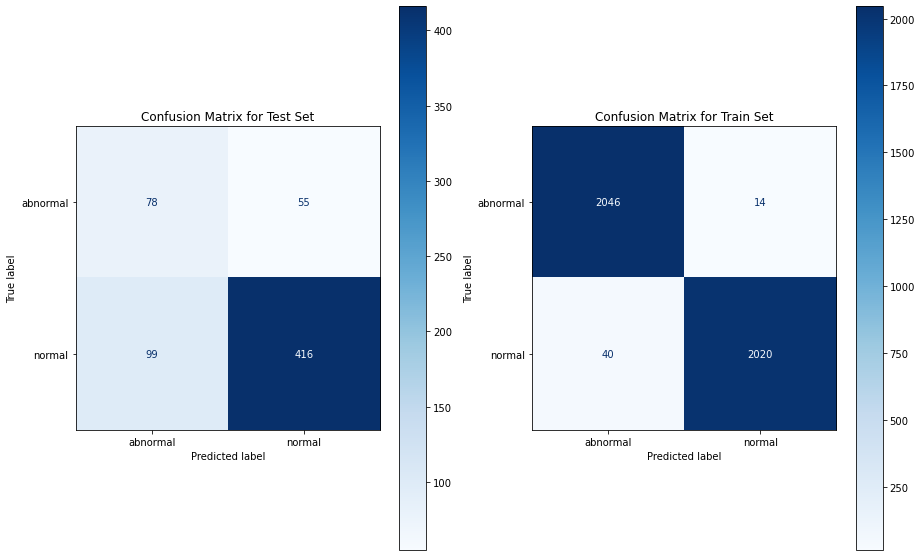

In [77]:
xg_smote = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_smote.fit(X_train_smote.values, y_train_smote)

print("Fitting Done")

report, model_scores["XGBoost_smote"] = print_results(xg_smote, 
                                                      X_train_smote.values, 
                                                      y_train_smote, 
                                                      X_test.values, y_test)

report

### Train-Test SMOTE PCA

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.48     0.88      0.78       0.68          0.79
      recall         0.53     0.85      0.78       0.69          0.78
      f1-score       0.50     0.86      0.78       0.68          0.79
      support      133.00   515.00      0.78     648.00        648.00
TRAIN precision      0.94     0.98      0.96       0.96          0.96
      recall         0.98     0.94      0.96       0.96          0.96
      f1-score       0.96     0.96      0.96       0.96          0.96
      support     2060.00  2060.00      0.96    4120.00       4120.00

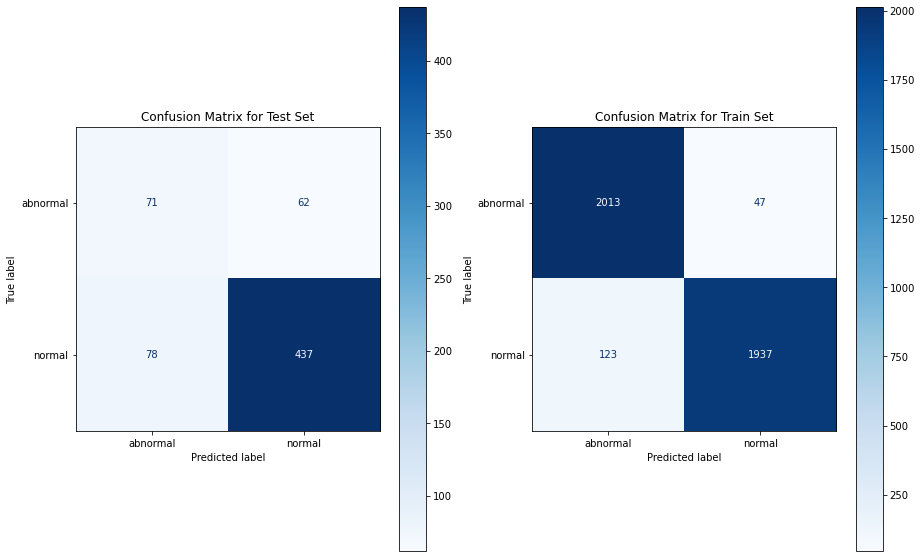

In [78]:
xg_smote_pca = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Done")
report, model_scores["XGBoost_smote_pca"] = print_results(xg_smote_pca, 
                                                          X_train_smote_pca, 
                                                          y_train_smote, 
                                                          X_test_pca, y_test)

report

## LightGBM


#### Params

In [79]:
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
#         'feature_name' : list(X_train.columns),
        # 'cat_features': categorical,
        'depth':10,
        'eval_metric':'AUC',
        # 'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 42,
#         'class_weight' :  'balanced'
          }


### Train-Test Original

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.73     0.81      0.81       0.77          0.79
      recall         0.08     0.99      0.81       0.54          0.81
      f1-score       0.15     0.89      0.81       0.52          0.74
      support      133.00   515.00      0.81     648.00        648.00
TRAIN precision      0.99     0.93      0.94       0.96          0.94
      recall         0.69     1.00      0.94       0.85          0.94
      f1-score       0.82     0.96      0.94       0.89          0.93
      support      532.00  2060.00      0.94    2592.00       2592.00

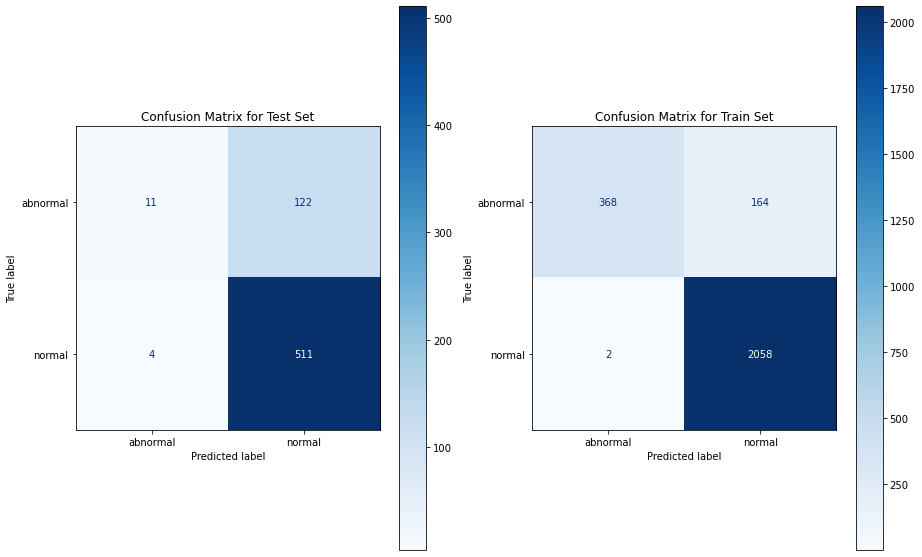

In [80]:
# num_boost_round=100
light = lgb.LGBMClassifier(**params)
light.fit(X_train.values, y_train)

print("Fitting Done")
report, model_scores["LightGBM"] =  print_results(light, X_train.values, 
                                                 y_train, X_test.values,
                                                 y_test)

report

### Train-Test PCA

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.76     0.82      0.82       0.79          0.81
      recall         0.17     0.99      0.82       0.58          0.82
      f1-score       0.27     0.90      0.82       0.58          0.77
      support      133.00   515.00      0.82     648.00        648.00
TRAIN precision      0.98     0.92      0.93       0.95          0.93
      recall         0.67     1.00      0.93       0.83          0.93
      f1-score       0.80     0.96      0.93       0.88          0.92
      support      532.00  2060.00      0.93    2592.00       2592.00

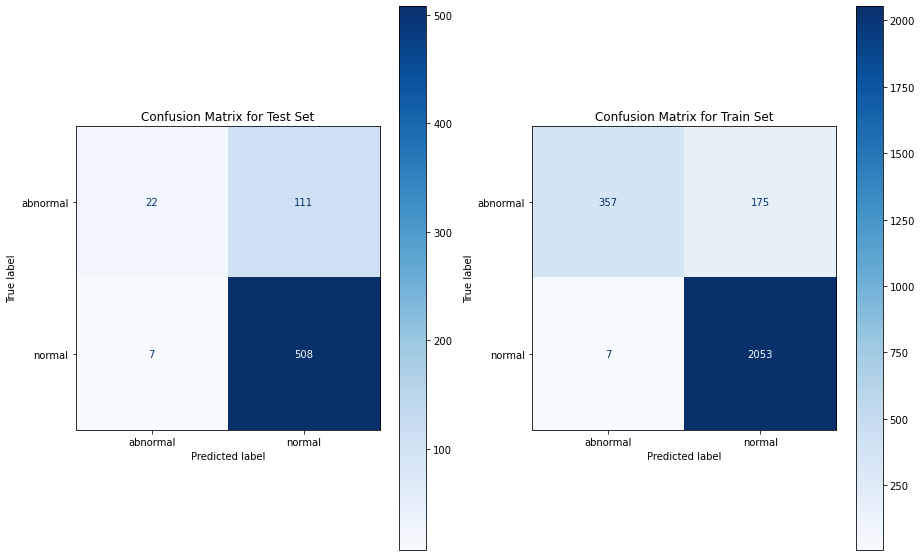

In [81]:
# num_boost_round=100
light_pca = lgb.LGBMClassifier(**params)
light_pca.fit(X_train_pca, y_train)

print("Fitting Done")

report, model_scores["LightGBM_pca"] =  print_results(light_pca, X_train_pca, 
                                                 y_train, X_test_pca,
                                                 y_test)

report

### Train-Test SMOTE

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.44     0.89      0.76       0.66          0.80
      recall         0.60     0.80      0.76       0.70          0.76
      f1-score       0.51     0.84      0.76       0.68          0.77
      support      133.00   515.00      0.76     648.00        648.00
TRAIN precision      0.94     0.96      0.95       0.95          0.95
      recall         0.96     0.94      0.95       0.95          0.95
      f1-score       0.95     0.95      0.95       0.95          0.95
      support     2060.00  2060.00      0.95    4120.00       4120.00

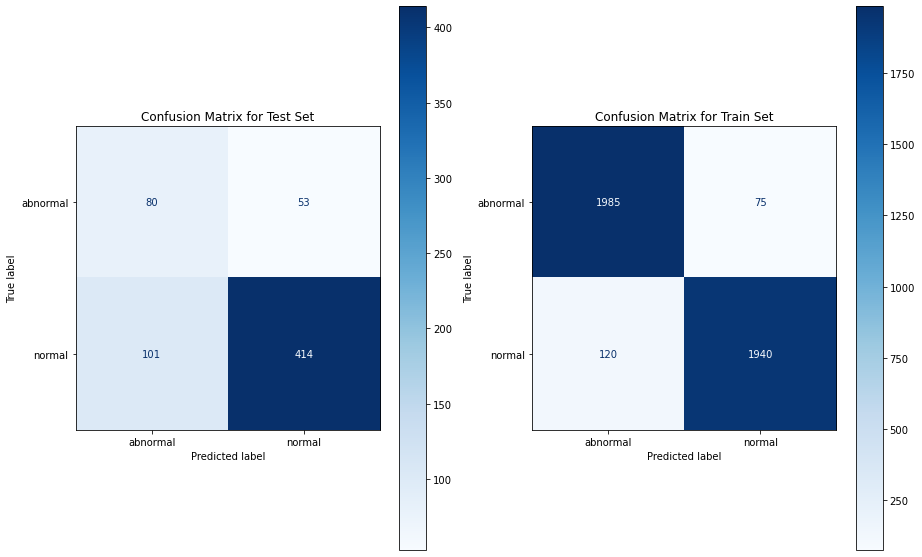

In [82]:
# num_boost_round=100
light_smote = lgb.LGBMClassifier(**params)
light_smote.fit(X_train_smote.values, y_train_smote)

print("Fitting Done")

report, model_scores["LightGBM_smote"] =  print_results(light_smote,
                                                        X_train_smote.values, 
                                                        y_train_smote, 
                                                        X_test.values,
                                                        y_test)

report

### Train-Test SMOTE PCA

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.48     0.89      0.78       0.68          0.80
      recall         0.58     0.84      0.78       0.71          0.78
      f1-score       0.52     0.86      0.78       0.69          0.79
      support      133.00   515.00      0.78     648.00        648.00
TRAIN precision      0.90     0.94      0.92       0.92          0.92
      recall         0.94     0.90      0.92       0.92          0.92
      f1-score       0.92     0.92      0.92       0.92          0.92
      support     2060.00  2060.00      0.92    4120.00       4120.00

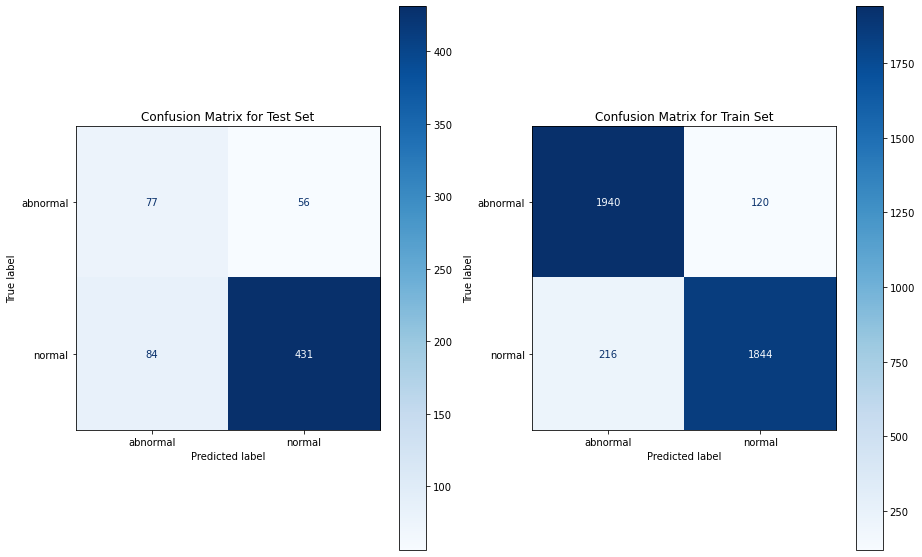

In [83]:
# num_boost_round=100
light_smote_pca = lgb.LGBMClassifier(**params)
light_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Done")

report, model_scores["LightGBM_smote_pca"] =  print_results(light_smote_pca,
                                                        X_train_smote_pca, 
                                                        y_train_smote, 
                                                        X_test_pca,
                                                        y_test)

report

# Modeling Results

In [84]:
print("ALL Done")

ALL Done


In [85]:
pd.DataFrame(model_scores).transpose()

,test_recall,train_recall,test_precision,train_precision,test_f1-score,train_f1-score,test_accuracy,train_accuracy
lr,0.62,0.74,0.26,0.33,0.37,0.46,0.56,0.64
lr_pca,0.62,0.72,0.27,0.28,0.38,0.40,0.58,0.55
lr_smote,0.65,0.82,0.26,0.67,0.37,0.74,0.55,0.71
lr_smote_pca,0.76,0.78,0.27,0.60,0.40,0.68,0.52,0.63
tree,0.40,1.00,0.31,1.00,0.35,1.00,0.70,1.00
tree_pca,0.22,1.00,0.34,1.00,0.26,1.00,0.75,1.00
tree_smote,0.35,1.00,0.25,1.00,0.29,1.00,0.65,1.00
tree_smote_pca,0.41,1.00,0.30,1.00,0.34,1.00,0.68,1.00
forest,0.52,0.83,0.36,0.55,0.43,0.66,0.71,0.83
forest_pca,0.22,0.81,0.48,0.49,0.30,0.61,0.79,0.79
